## Detecting Phishing Websites Using URL-Based, HTML-Based, and Domain-Based Features

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [26]:
df2.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:

df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [27]:
df.shape

(11430, 89)

In [29]:
df2["status"].value_counts(normalize=True)  

status
legitimate    0.5
phishing      0.5
Name: proportion, dtype: float64

In [31]:
df2.describe().T


,count,mean,std,min,25%,50%,75%,max
length_url,11430.0,61.126684,5.529732e+01,12.0,33.00,47.0,71.00,1641.0
length_hostname,11430.0,21.090289,1.077717e+01,4.0,15.00,19.0,24.00,214.0
ip,11430.0,0.150569,3.576436e-01,0.0,0.00,0.0,0.00,1.0
nb_dots,11430.0,2.480752,1.369686e+00,1.0,2.00,2.0,3.00,24.0
nb_hyphens,11430.0,0.997550,2.087087e+00,0.0,0.00,0.0,1.00,43.0
...,...,...,...,...,...,...,...,...
domain_age,11430.0,4062.543745,3.107785e+03,-12.0,972.25,3993.0,7026.75,12874.0
web_traffic,11430.0,856756.643307,1.995606e+06,0.0,0.00,1651.0,373845.50,10767986.0
dns_record,11430.0,0.020122,1.404254e-01,0.0,0.00,0.0,0.00,1.0
google_index,11430.0,0.533946,4.988682e-01,0.0,0.00,1.0,1.00,1.0


<Axes: >

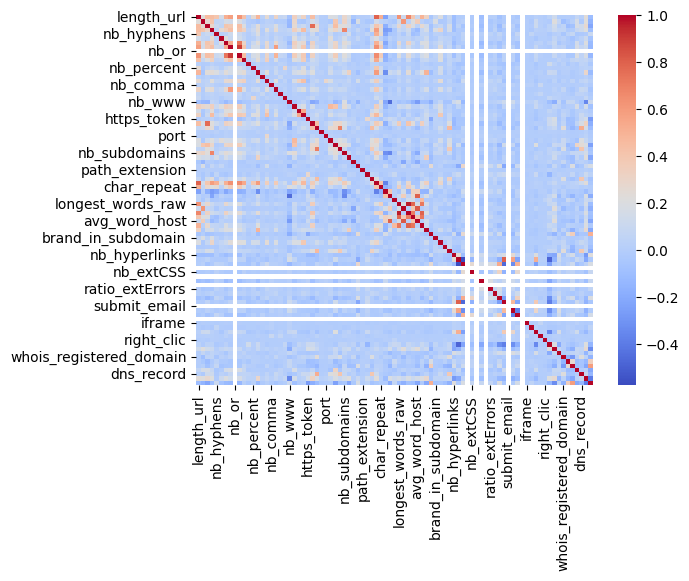

In [ ]:
corr = df2.drop(columns=["url", "status"]).corr()
sns.heatmap(corr, cmap="coolwarm", vmax=1, vmin=-1)


count    11430.000000
mean         0.053137
std          0.089363
min          0.000000
25%          0.000000
50%          0.000000
75%          0.079365
max          0.723881
Name: ratio_digits_url, dtype: float64

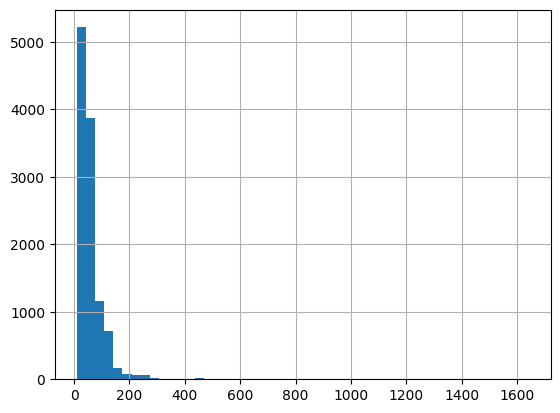

In [34]:
df2["length_url"].hist(bins=50)
df2["nb_dots"].value_counts()
df2["ratio_digits_url"].describe()


Analysis of ratio_digits_url

The distribution of ratio_digits_url shows a pronounced right skew, with most URLs containing very few numeric characters relative to their overall length. The median sits at zero, which means at least half of all URLs include no digits at all. However, the long tail stretching toward the maximum value of approximately 0.72 reveals that a subset of URLs contains disproportionately high numeric density. This behaviour is characteristic of phishing infrastructure, where attackers frequently embed long numeric sequences to mimic session identifiers, obfuscate malicious patterns, or generate large batches of automated URLs.

Example implication:
A phishing URL such as
http://secure-login-verify-410873298.com/update/928374/confirm
exhibits a high digit ratio because both the hostname and path rely heavily on numeric padding to appear complex or legitimate.

Why this matters:
The skew indicates that while most legitimate domains remain alphanumeric with minimal digit usage, phishing URLs often inflate their numeric footprint. This separation makes ratio_digits_url a valuable discriminator for machine learning models, especially when combined with complementary lexical features like nb_dots, nb_hyphens, and length_url.

In [35]:
df.groupby("status")[["domain_age", "domain_registration_length", "google_index"]].mean()


,domain_age,domain_registration_length,google_index
status,,,
legitimate,5093.938408,624.289939,0.169204
phishing,3031.149081,360.774453,0.898688
